this notebook is to test the synthetic occlusion loss methods

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import numpy as np
import tensorflow as tf
import random
import cv2
import math
import matplotlib.pyplot as plt
%matplotlib inline

import sys
sys.path.append("../")
from data.occnet_data_loader import OccnetTfrecordLoader
from network.main import Transformer

In [2]:
sess = tf.Session()

In [3]:
vw, vh = 128, 128 # width, height

In [4]:
OCCNET_DATASET_PATH = "../datasets/400/"

In [5]:
occnet_dataloader = OccnetTfrecordLoader(OCCNET_DATASET_PATH, occnet_data=True)
occnet_transformer = Transformer(128, 128, OCCNET_DATASET_PATH, occnet=True)
occnet_features = occnet_dataloader.get_features()

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [6]:
images = occnet_features['img0_png']
mask = images[:, :, :, 3]
mask = tf.cast(tf.greater(mask, tf.zeros_like(mask)), dtype=tf.float32)

In [25]:
def get_box_from_mask(mask):
    # returns the bounding given a mask
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    ymin, ymax = np.where(rows)[0][[0, -1]]
    xmin, xmax = np.where(cols)[0][[0, -1]]
    x, y, w, h = int(xmin), int(ymin), int(xmax-xmin), int(ymax-ymin)
    box = [x,y,w,h]
    return box

def get_box_pieces(box, num_cols=2, num_rows=2):
    # returns array of bounding boxes
    num_cols = 2
    num_rows = 2
    x,y,w,h = box
    x_vals = np.linspace(x,x+w, num_cols + 1)
    col_size = w // num_cols
    y_vals = np.linspace(y,y+h, num_rows + 1)
    row_size = h // num_rows
    
    boxes = []
    for c in x_vals[:-1]:
        for r in y_vals[:-1]:
            current_box = [int(c), int(r), int(col_size), int(row_size)]
            boxes.append(current_box)
        
    return boxes

def get_numpy_mask_from_box(box):
    mask = np.zeros((128,128))
    x,y,w,h = box
    mask[y:y+h,x:x+w] = 1
    mask = 1 - mask
    return mask.astype("uint8")

def occlusion_loss(images, mask, loss_occ=0.0):
    new_images = images.copy()
    for i in range(len(images)):
        # with some probability, we will not use an occlusion
        if random.uniform(0, 1) >= loss_occ:
            pass
        else:
            box = get_box_from_mask(mask[i])
            boxes = get_box_pieces(box)
            box_index = random.randint(0, len(boxes)-1)
            used_mask = get_numpy_mask_from_box(boxes[box_index])
            new_images[i][:,:,0] *= used_mask
            new_images[i][:,:,1] *= used_mask
            new_images[i][:,:,2] *= used_mask
    return new_images.astype("float32")

In [26]:
masked_images = tf.py_func(occlusion_loss, [images, mask, 1.0], tf.float32)

In [27]:
masked_images.set_shape([None, 128, 128, 3])

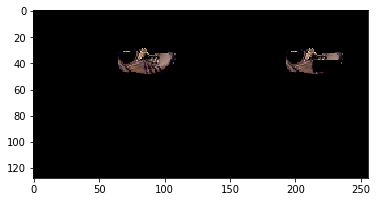

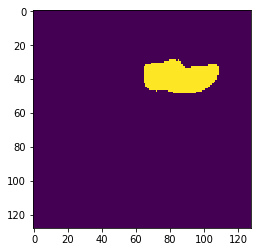

In [34]:
np_images, np_masked_images, np_mask = sess.run([images, masked_images, mask])

original = np_images[0, :, :, :3]
occluded = np_masked_images[0, :, :, :3].astype(int)

combined = np.hstack([original, occluded])
plt.imshow(combined)
plt.show()
plt.imshow(np_mask[0])
plt.show()